<a href="https://colab.research.google.com/github/Arpitk98/MathQuiz/blob/main/Major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
import jovian

In [ ]:
#Make directory name kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download ambarish/breakhis

Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
100% 3.98G/3.99G [03:25<00:00, 23.0MB/s]
100% 3.99G/3.99G [03:25<00:00, 20.8MB/s]


In [ ]:
from zipfile import ZipFile
file = "breakhis.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    zip.extractall()
    print('Done!')

Done!


Training set class distribution: Counter({1: 4803, 0: 2036})
Validation set class distribution: Counter({1: 626, 0: 444})
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/214 ━━━━━━━━━━━━━━━━━━━━ 44s 157ms/step - accuracy: 0.7371 - loss: 2.9713 - val_accuracy: 0.5850 - val_loss: 63.7081
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 69s 126ms/step - accuracy: 0.7934 - loss: 0.7081 - val_accuracy: 0.5850 - val_loss: 73.1337
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - accuracy: 0.8229 - loss: 0.6625 - val_accuracy: 0.7112 - val_loss: 1.0289
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.8120 - loss: 0.7287 - val_accuracy: 0.7271 - val_loss: 0.6803
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.8234 - loss: 0.3937 - val_accuracy: 0.8271 - val_loss: 0.5984
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.8163 - loss: 0.5576 - val_accuracy: 0.5234 - val_loss: 3.6255
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.8435 - loss: 0.3660 - val_accuracy: 0.8822 - val_loss: 0.3522
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.8495 - loss: 0.3252 - v

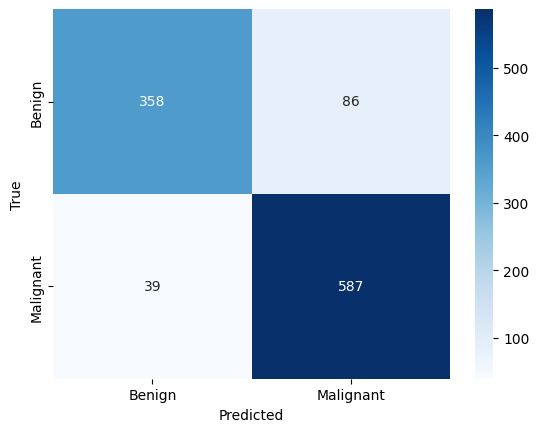

ROC-AUC score: 0.9269529113778315


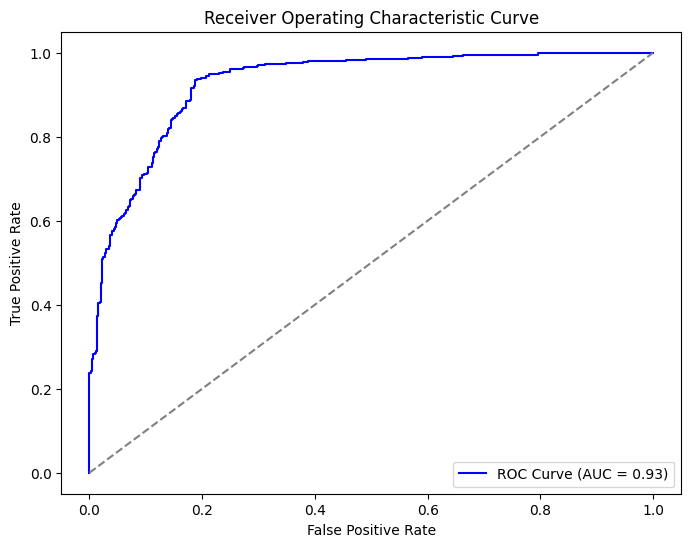

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import glob
import os

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10

# Define the path to your uploaded dataset
base_path = 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
breast_img_paths = glob.glob(os.path.join(base_path, '**', '*.png'), recursive=True)

# Initialize data structures
patient_images = defaultdict(list)

# Load images and assign labels based on patient-wise grouping
for path in breast_img_paths:
    patient_id = path.split('/')[-4]
    img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0
    label = 1 if 'malignant' in path.lower() else 0
    patient_images[patient_id].append((img, label))


patient_ids = list(patient_images.keys())
train_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)

# Populate training and validation data based on patient grouping
train_data, train_labels = [], []
val_data, val_labels = [], []

for patient_id in train_ids:
    for img, label in patient_images[patient_id]:
        train_data.append(img)
        train_labels.append(label)

for patient_id in val_ids:
    for img, label in patient_images[patient_id]:
        val_data.append(img)
        val_labels.append(label)

# Convert to NumPy arrays
X_train, X_val = np.array(train_data), np.array(val_data)
y_train, y_val = np.array(train_labels), np.array(val_labels)

# Check class distribution
print("Training set class distribution:", Counter(y_train))
print("Validation set class distribution:", Counter(y_val))

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Custom CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Model Training
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

# Evaluation on Validation Data
predictions = model.predict(X_val)
y_pred_prob = predictions.flatten()

# Thresholding to get final predictions
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# Classification Report and Confusion Matrix
print(classification_report(y_val, y_pred, target_names=['Benign', 'Malignant']))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC-AUC Score
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"ROC-AUC score: {auc_score}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()
